In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import gym
import dacmdp
import dacmdp.envs as ce
import wandb as wandb_logger


/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/mujoco_py/builder.py:9: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  from distutils.sysconfig import customize_compiler
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'

In [ ]:
from munch import munchify 

config = munchify({
"envArgs":{'env_name': 'CartPole-cont-v1', 'seed': 0},
"logArgs":{'wandb_id': "cartpole_online_test_1", "wandb_entity":"dacmdp",
           "wandb_project":"dacmdp_online_test_v0", "no_wandb_logging":True},
"dataArgs": {'buffer_name': 'random', 'buffer_size': 25000, 
             'load_buffer': False, 'buffer_device': 'gpu', "data_dir":""},
"reprModelArgs": {'repr_model_name': 'OracleDynamicsRepr', 's_multiplyer': 1, 'a_multiplyer': 10, 'repr_dim': 4},
"actionModelArgs": {'action_model_name': 'NNActionModelCuda', 'nn_engine': "torch_pykeops"},
"mdpBuildArgs": {'n_tran_types': 10, 'n_tran_targets': 5, 'penalty_beta': 1.0, 'penalty_type': 'linear', 'rebuild_mdpfcache': False,
                 'save_mdp2cache': False, 'save_folder': '/nfs/hpc/share/shrestaa/storage/dac_storage_22_Q4/mdp_dumps/random_hash'},
"mdpSolveArgs": {'device': 'cuda', 'max_n_backups': 5000, "gamma": 0.99, 'epsilon': 0.0001, 'penalty_beta': 1, "operator": "simple_backup"},
"evalArgs": {'eval_episode_count': 50, "skip_eval":True, "skip_dist_log":True},
})

flat_args = lambda config : {f"{K}::{k}":v for K in config for k,v in config[K].items() if K != "flat_args"}

In [ ]:
config.logArgs

Munch({'wandb_id': 'cartpole_online_test_1', 'wandb_entity': 'dacmdp', 'wandb_project': 'dacmdp_online_test_v0', 'no_wandb_logging': True})

In [ ]:
if not config.logArgs.no_wandb_logging:
    wandb_logger.init( id = config.logArgs.wandb_id ,
        entity=config.logArgs.wandb_entity,
        project=config.logArgs.wandb_project,
        config = flat_args(config),
        resume = "allow")

In [ ]:
env = gym.make(config.envArgs.env_name)

In [7]:
from dacmdp.core.models_action import NNActionModel, GlobalClusterActionModel, EnsembleActionModel
from dacmdp.core.models_sa_repr import OracleDynamicsRepr, DeltaPredictonRepr

######### Get Action and Repr Models ####################################
seed_buffer = dacmdp.utils_buffer.generate_or_load_buffer(config, env)
cluster_action_count = 10
cluster_action_model = GlobalClusterActionModel(action_space=env.action_space,
                                   n_actions= cluster_action_count,
                                   data_buffer=seed_buffer)

sa_repr_model = OracleDynamicsRepr(env_name = config.envArgs.env_name)

######################################################################################################

Average Reward of collected trajectories:16.702
Collected buffer!


In [8]:
cluster_action_model.cand_actions_for_states(torch.FloatTensor(seed_buffer.state[0:100]).cuda()).shape,\
sa_repr_model.encode_state_action_pairs(torch.FloatTensor(seed_buffer.state[0:100]),
                                       torch.FloatTensor(seed_buffer.action[0:100])).shape

/nfs/guille/afern/users/shrestaa/workspaces/dacmdp/dacmdp/envs/cont_cartpole.py:104: UserWarning: WARN: 
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undnp.float32(low), np.float32(high)efined behavior.
                
  logger.warn("""


(torch.Size([100, 10, 1]), torch.Size([100, 4]))

In [9]:
from dacmdp.data.utils_buffer import StandardElasticBuffer
global_buffer = StandardElasticBuffer(state_shape = env.observation_space.shape,
               action_shape = [len(env.action_space.sample())], # for discrete settings. 
                batch_size=32, buffer_size=100000, device="cpu")
# policy liftup functions
def dummy_lifted_policy(Agent, s, epsilon):
    if torch.rand(1).item() < epsilon:
        return env.action_space.sample()
    else:
        nn_s_idx =  THelper.calc_knn_indices(torch.FloatTensor(s).to(Agent.device), Agent.dacmdp_core.S, 1)[0]
        policy_idx = Agent.dacmdp_core.Pi[nn_s_idx] 
        return Agent.A_names[nn_s_idx,policy_idx].cpu().numpy()

In [10]:
import time
import matplotlib.pyplot as plt 
import numpy as np 
from dacmdp.core.utils_misc import plot_distributions_as_rgb_array
from dacmdp.eval.utils_eval import evaluate_on_env
from dacmdp.data.utils_buffer import StandardBuffer
from dacmdp.core.dac_core import DACTransitionBatch
from dacmdp.core.dac_build import DACBuildWithActionNames
from dacmdp.core.utils_knn import THelper

total_training_points = 200000
point_batch_size = 10000
curr_data_points = 0
avg_rewards = 0
rewards_log = []
dac_plot_log = []
images = 0

# Instantiate Elastic Agent
config.mdpBuildArgs.n_tran_types = cluster_action_count + 5
elasticAgent = DACBuildWithActionNames( config = config, 
                                    action_space = env.action_space, 
                                    action_model = cluster_action_model, # Update this later.
                                    repr_model = sa_repr_model, 
                                    effective_batch_size= 1000, 
                                    batch_calc_knn_ret_flat_engine = THelper.batch_calc_knn_ret_flat_pykeops
                                    )

for epoch_i in range(total_training_points//point_batch_size):
    ######### TT 1: Data collect   ###########################################################################
    random_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 1)
    explore_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0.1)
    optimal_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        
    data_buffer = StandardBuffer(state_shape = env.observation_space.shape,
                           action_shape = [len(env.action_space.sample())], # for discrete settings. 
                            batch_size=32, buffer_size=point_batch_size, device="cpu")
    data_buffer, info_explore = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else explore_policy,
                                                   episode_count=99999, 
                                                   frame_count=int(point_batch_size/2))
    data_buffer, info_optimal = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else optimal_policy,
                                                   episode_count=99999, 
                                                   frame_count=int(point_batch_size/2))
    global_buffer.append_buffer(data_buffer)
    ######################################################################################################
    
    
    ######### TT 2: Update Action Model  ###########################################################################
    # Action Model
    nn_action_model = NNActionModel(action_space = env.action_space,
                                   n_actions = 5,
                                   data_buffer = global_buffer,
                                   nn_engine= config.actionModelArgs.nn_engine,
                                   projection_fxn=lambda s: s, 
                                   )
    action_model = EnsembleActionModel(env.action_space,[nn_action_model, cluster_action_model])
    # action_model = cluster_action_model
    config.mdpBuildArgs.n_tran_types = action_model.n_actions
    elasticAgent.action_model = action_model
    
    sa_repr_model = DeltaPredictonRepr(s_multiplyer=2, 
                                   a_multiplyer=1,
                                   buffer=global_buffer,
                                   nn_engine="torch_pykeops")
    elasticAgent.repr_model = sa_repr_model
    ######################################################################################################
    

    ######### TT 3: DACMDP Elastic Build   ###########################################################################
    transitions = DACTransitionBatch(torch.FloatTensor(data_buffer.state).clone().detach(),
                                    torch.FloatTensor(data_buffer.action).clone().detach(),
                                    torch.FloatTensor(data_buffer.next_state).clone().detach(),
                                    torch.FloatTensor(data_buffer.reward.reshape(-1)).clone().detach(), 
                                    torch.LongTensor((1- data_buffer.not_done).reshape(-1)).clone().detach())

    st = time.time()
    elasticAgent.consume_transitions(transitions, verbose = True, batch_size = 1000)
    elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
                                   penalty_beta = config.mdpSolveArgs.penalty_beta, 
                                   epsilon = config.mdpSolveArgs.epsilon, 
                                   gamma = config.mdpSolveArgs.gamma, 
                                   operator="simple_backup", 
                                   bellman_backup_batch_size=500)

    print(f"Epoch {epoch_i}: Graph built and solved in {time.time()-st:.2f} Seconds")
    ######################################################################################################

    
    ######### TT 4: Eval  ###########################################################################
    if not config.evalArgs.skip_eval:
        st = time.time()
        eval_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        config.evalArgs.eval_episode_count = 100
        avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
        eval_time =  time.time()-st
        print(f"Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")
        rewards_log.append(avg_rewards)
        
    if not config.evalArgs.skip_dist_log:
        image_array= plot_distributions_as_rgb_array(elasticAgent.dacmdp_core.mdp_distributions)
        dac_plot_log.append(image_array)
        images = wandb_logger.Image(image_array, caption="MDP Distributions")
    
    if not config.logArgs.no_wandb_logging:   
        wandb_logger.log({"epoch_i":epoch_i, "buffer_size":len(global_buffer), "Average Reward":avg_rewards,
                         "explore_data_collection_traj_reward":np.mean(info_explore["all_rewards"]), 
                         "optimal_data_collection_traj_reward":np.mean(info_optimal["all_rewards"]), 
                         "mdp_distribution":images
                         })

    ######################################################################################################

dacmdp_core_defined
Using pre-initialized Action Model GlobalClusterActionModel
Using pre-initialized Action Model <dacmdp.core.models_sa_repr.OracleDynamicsRepr object at 0x2b157b4343d0>
Average Reward of collected trajectories:18.266
Average Reward of collected trajectories:18.531


Caculating State Representations: : 40it [00:00, 21732.15it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(10000, 15, 5)
nn after consumption,  10000


Calculate Candidate Actions: : 10it [00:00, 240.43it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 507.83it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 300.83it/s]
Update Transition model of core dacmdp: : 10it [00:00, 294.84it/s]


0 tensor(1.)
500 tensor(0.0066)
1000 tensor(9.1553e-05)
Solved MDP in 1000 Backups
Epoch 0: Graph built and solved in 1.03 Seconds
Average Reward of collected trajectories:170.774
Average Reward of collected trajectories:339.438


Caculating State Representations: : 79it [00:00, 42943.24it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(20000, 15, 5)
nn after consumption,  20000


Calculate Candidate Actions: : 10it [00:00, 231.98it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 406.72it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 235.89it/s]
Update Transition model of core dacmdp: : 10it [00:00, 244.80it/s]

0 tensor(99.9289)


500 tensor(0.0011)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 1: Graph built and solved in 0.29 Seconds
Average Reward of collected trajectories:174.379
Average Reward of collected trajectories:436.0


Caculating State Representations: : 118it [00:00, 64242.97it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(30000, 15, 5)
nn after consumption,  30000


Calculate Candidate Actions: : 10it [00:00, 214.00it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 326.85it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 224.91it/s]
Update Transition model of core dacmdp: : 10it [00:00, 183.58it/s]


0 tensor(99.9958)
500 tensor(0.0002)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 2: Graph built and solved in 0.36 Seconds
Average Reward of collected trajectories:217.87
Average Reward of collected trajectories:435.667


Caculating State Representations: : 157it [00:00, 79023.85it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(40000, 15, 5)
nn after consumption,  40000


Calculate Candidate Actions: : 10it [00:00, 190.54it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 316.94it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 201.93it/s]
Update Transition model of core dacmdp: : 10it [00:00, 193.00it/s]


0 tensor(99.9987)
500 tensor(0.0006)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 3: Graph built and solved in 0.38 Seconds
Average Reward of collected trajectories:211.56
Average Reward of collected trajectories:444.833


Caculating State Representations: : 196it [00:00, 98088.96it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(50000, 15, 5)
nn after consumption,  50000


Calculate Candidate Actions: : 10it [00:00, 166.06it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 271.44it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 178.65it/s]
Update Transition model of core dacmdp: : 10it [00:00, 166.42it/s]


0 tensor(99.9982)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 4: Graph built and solved in 0.46 Seconds
Average Reward of collected trajectories:258.667
Average Reward of collected trajectories:425.167


Caculating State Representations: : 235it [00:00, 114345.87it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(60000, 15, 5)
nn after consumption,  60000


Calculate Candidate Actions: : 10it [00:00, 152.36it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 244.32it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 171.98it/s]
Update Transition model of core dacmdp: : 10it [00:00, 155.97it/s]


0 tensor(99.9981)
500 tensor(0.0020)
1000 tensor(2.2888e-05)
Solved MDP in 1000 Backups
Epoch 5: Graph built and solved in 0.50 Seconds
Average Reward of collected trajectories:224.0
Average Reward of collected trajectories:465.818


Caculating State Representations: : 274it [00:00, 130536.04it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(70000, 15, 5)
nn after consumption,  70000


Calculate Candidate Actions: : 10it [00:00, 133.99it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 216.41it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 155.12it/s]
Update Transition model of core dacmdp: : 10it [00:00, 141.78it/s]


0 tensor(99.9978)
500 tensor(0.0057)
1000 tensor(3.8147e-05)
Solved MDP in 1000 Backups
Epoch 6: Graph built and solved in 0.57 Seconds
Average Reward of collected trajectories:237.273
Average Reward of collected trajectories:419.923


Caculating State Representations: : 313it [00:00, 141467.37it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(80000, 15, 5)
nn after consumption,  80000


Calculate Candidate Actions: : 10it [00:00, 127.58it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 199.86it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 144.76it/s]
Update Transition model of core dacmdp: : 10it [00:00, 130.28it/s]


0 tensor(99.9980)
500 tensor(0.0043)
1000 tensor(3.0518e-05)
Solved MDP in 1000 Backups
Epoch 7: Graph built and solved in 0.61 Seconds
Average Reward of collected trajectories:201.72
Average Reward of collected trajectories:425.167


Caculating State Representations: : 352it [00:00, 152994.30it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(90000, 15, 5)
nn after consumption,  90000


Calculate Candidate Actions: : 10it [00:00, 116.61it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 184.69it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 136.76it/s]
Update Transition model of core dacmdp: : 10it [00:00, 119.80it/s]


0 tensor(99.9985)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 8: Graph built and solved in 0.68 Seconds
Average Reward of collected trajectories:266.316
Average Reward of collected trajectories:427.75


Caculating State Representations: : 391it [00:00, 171778.87it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(100000, 15, 5)
nn after consumption,  100000


Calculate Candidate Actions: : 10it [00:00, 95.36it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 158.97it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 121.89it/s]
Update Transition model of core dacmdp: : 10it [00:00, 108.27it/s]


0 tensor(99.9978)
500 tensor(6.1035e-05)
Solved MDP in 500 Backups
Epoch 9: Graph built and solved in 0.58 Seconds
Average Reward of collected trajectories:221.652
Average Reward of collected trajectories:430.333


Caculating State Representations: : 430it [00:00, 182693.55it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(110000, 15, 5)
nn after consumption,  110000


Calculate Candidate Actions: : 10it [00:00, 102.02it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 157.66it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 121.14it/s]
Update Transition model of core dacmdp: : 10it [00:00, 104.54it/s]


0 tensor(99.9982)
500 tensor(0.0007)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 10: Graph built and solved in 0.79 Seconds
Average Reward of collected trajectories:196.296
Average Reward of collected trajectories:457.583


Caculating State Representations: : 469it [00:00, 191466.67it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(120000, 15, 5)
nn after consumption,  120000


Calculate Candidate Actions: : 10it [00:00, 92.31it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 144.70it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 110.96it/s]
Update Transition model of core dacmdp: : 10it [00:00, 94.26it/s]


0 tensor(99.9978)
500 tensor(0.0009)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 11: Graph built and solved in 0.86 Seconds
Average Reward of collected trajectories:266.1
Average Reward of collected trajectories:496.0


Caculating State Representations: : 508it [00:00, 202327.08it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(130000, 15, 5)
nn after consumption,  130000


Calculate Candidate Actions: : 10it [00:00, 87.53it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 136.77it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 106.31it/s]
Update Transition model of core dacmdp: : 10it [00:00, 89.39it/s]


0 tensor(99.9983)
500 tensor(7.6294e-05)
Solved MDP in 500 Backups
Epoch 12: Graph built and solved in 0.67 Seconds
Average Reward of collected trajectories:231.87
Average Reward of collected trajectories:451.833


Caculating State Representations: : 547it [00:00, 213580.74it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(140000, 15, 5)
nn after consumption,  140000


Calculate Candidate Actions: : 10it [00:00, 83.12it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 129.83it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 102.67it/s]
Update Transition model of core dacmdp: : 10it [00:00, 85.39it/s]


0 tensor(99.9980)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 13: Graph built and solved in 0.95 Seconds
Average Reward of collected trajectories:231.5
Average Reward of collected trajectories:469.273


Caculating State Representations: : 586it [00:00, 223279.63it/s]
/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  warnings.warn(


Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x2b150115c4c0>> (for post_execute):



KeyboardInterrupt



KeyboardInterrupt: 

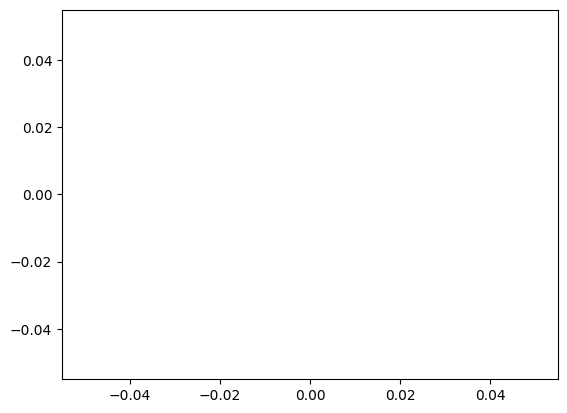

In [13]:
import matplotlib.pyplot as plt 
plt.plot(rewards_log)